Simply QNN

In [11]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Time series data
time = np.arange(0, 1000, 1)
demand = 0.05 * time + np.sin(time * 0.1) + np.random.normal(0, 0.5, size=len(time))

# Synthetic features
population = np.linspace(50, 60, num=len(time)) + np.random.normal(0, 1, size=len(time))  # Growing population
temperature = 20 + 10 * np.sin(time * 0.01) + np.random.normal(0, 2, size=len(time))  # Seasonal temperature
sunlight = 5 + 3 * np.sin(time * 0.05) + np.random.normal(0, 0.5, size=len(time))  # Varied sunlight exposure

# Stack features together
features = np.stack([time, population, temperature, sunlight, demand], axis=1)

# Shift demand to create a prediction task
X = features[:-1]  # All but last
Y = features[1:, -1]  # Demand shifted by one

# Split into training and testing sets
split_time = 800
X_train, X_test = X[:split_time], X[split_time:]
Y_train, Y_test = Y[:split_time], Y[split_time:]
# Assuming Y_train and Y_test are your original demand values
Y_train_expanded = np.tile(Y_train, (3, 1)).T  # Replicate Y_train across 3 columns
Y_test_expanded = np.tile(Y_test, (3, 1)).T  # Replicate Y_test across 3 columns

Y_train_torch = torch.tensor(Y_train_expanded, dtype=torch.float32)
Y_test_torch = torch.tensor(Y_test_expanded, dtype=torch.float32)

# Convert to PyTorch tensors
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
Y_train_torch = torch.tensor(Y_train, dtype=torch.float32).view(-1, 1)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
Y_test_torch = torch.tensor(Y_test, dtype=torch.float32).view(-1, 1)

# DataLoader for training data
train_dataset = TensorDataset(X_train_torch, Y_train_torch)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)


In [12]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, TensorDataset

# Model Definition
class QuantileModel(nn.Module):
    def __init__(self):
        super(QuantileModel, self).__init__()
        self.fc1 = nn.Linear(5, 128)  # Assuming 5 input features
        self.dropout1 = nn.Dropout(0.1)
        self.fc2 = nn.Linear(128, 128)
        self.dropout2 = nn.Dropout(0.1)
        self.fc3 = nn.Linear(128, 3)  # Outputting 3 quantiles

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        return self.fc3(x)

# Quantile Loss Function
def quantile_loss(q, y, f):
    e = y - f
    v = torch.max(q * e, (q-1) * e)
    return torch.mean(v)

# Assuming synthetic data creation and preprocessing has been done correctly
# Example: X_train, Y_train, X_test, Y_test

# Preparing target data for three quantiles
Y_train_expanded = np.tile(Y_train, (3, 1)).T  # Replicate Y_train across 3 columns
Y_test_expanded = np.tile(Y_test, (3, 1)).T  # Replicate Y_test across 3 columns

X_train_torch = torch.tensor(X_train, dtype=torch.float32)
Y_train_torch = torch.tensor(Y_train_expanded, dtype=torch.float32)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
Y_test_torch = torch.tensor(Y_test_expanded, dtype=torch.float32)

# DataLoader for training data
train_dataset = TensorDataset(X_train_torch, Y_train_torch)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Model Initialization
model = QuantileModel()

# Optimizer and Learning Rate Scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

# Training Loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(x_batch)
        loss = sum([quantile_loss(torch.tensor([q]), y_batch[:, i], output[:, i]) 
                    for i, q in enumerate([0.25, 0.5, 0.75])])
        loss.backward()
        optimizer.step()
    scheduler.step()

    # Optional: Evaluation code here

print("Training completed.")

# Evaluation and printing predictions vs. actual values
# Add your evaluation code as previously described to visualize predictions


Training completed.


In [4]:
# Evaluation on Test Set with Predictions and Actual Results
test_dataset = TensorDataset(X_test_torch, Y_test_torch)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

total_loss = 0.0
predictions = []
actuals = []
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        output = model(x_batch)
        batch_loss = sum([quantile_loss(torch.tensor([q]), y_batch[:, i], output[:, i]) for i, q in enumerate([0.25, 0.5, 0.75])])
        total_loss += batch_loss.item()

        predictions.append(output)
        actuals.append(y_batch)

average_loss = total_loss / len(test_loader)
print(f"Average Test Loss: {average_loss:.4f}")

# Optionally, print a subset of predictions and actual values
# Flatten the list of batches into a single list of predictions and actuals
predictions_flat = torch.cat(predictions).numpy()
actuals_flat = torch.cat(actuals).numpy()

# Select a subset of predictions and actual values to display
for i in range(min(10, len(predictions_flat))):  # Change 10 to desired number of samples to display
    print(f"\nSample {i+1}:")
    print(f"Predicted Quantiles - 25th: {predictions_flat[i, 0]:.4f}, 50th: {predictions_flat[i, 1]:.4f}, 75th: {predictions_flat[i, 2]:.4f}")
    print(f"Actual Demand: {actuals_flat[i, 0]:.4f}")  # Adjust indexing if your actuals structure is different



Average Test Loss: 3.2929

Sample 1:
Predicted Quantiles - 25th: 36.7971, 50th: 38.6121, 75th: 40.9907
Actual Demand: 38.7920

Sample 2:
Predicted Quantiles - 25th: 38.3625, 50th: 39.7957, 75th: 42.4523
Actual Demand: 39.1521

Sample 3:
Predicted Quantiles - 25th: 32.9832, 50th: 34.5823, 75th: 38.3385
Actual Demand: 38.9367

Sample 4:
Predicted Quantiles - 25th: 37.9380, 50th: 40.7090, 75th: 41.9498
Actual Demand: 39.0243

Sample 5:
Predicted Quantiles - 25th: 35.1415, 50th: 37.3658, 75th: 38.6113
Actual Demand: 39.1703

Sample 6:
Predicted Quantiles - 25th: 37.7565, 50th: 40.7055, 75th: 42.0724
Actual Demand: 39.5284

Sample 7:
Predicted Quantiles - 25th: 35.8702, 50th: 37.9773, 75th: 40.1883
Actual Demand: 39.2793

Sample 8:
Predicted Quantiles - 25th: 39.8945, 50th: 43.5496, 75th: 45.1851
Actual Demand: 40.2562

Sample 9:
Predicted Quantiles - 25th: 39.4377, 50th: 42.8526, 75th: 44.3273
Actual Demand: 39.2984

Sample 10:
Predicted Quantiles - 25th: 35.7875, 50th: 37.8136, 75th: 39.9

QNN with optimization model
Base on 

In [13]:
import numpy as np
#Data generateion
def generate_data(num_samples=5000):
    #Seed
    np.random.seed(42)
    # Mock time and temperature
    time = np.random.uniform(0, 24, num_samples)
    temperature = np.random.uniform(15, 35, num_samples)
    # Actual demand for products (simple linear relationship with some noise)
    demand_x1 = 100 + 5 * time - 2 * temperature + np.random.normal(0, 10, num_samples)
    demand_x2 = 150 + 3 * time - temperature + np.random.normal(0, 10, num_samples)
    #Classified data
    X = np.stack([time, temperature], axis=1)
    Y = np.stack([demand_x1, demand_x2], axis=1)
    
    return X, Y

X, Y = generate_data()


In [15]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
# Generate data
X, Y = generate_data()

# Split data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)

# Create DataLoaders for training and test sets
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [16]:
import torch
import torch.nn as nn
from torch.optim import Adam



class EnhancedQNN(nn.Module):
    def __init__(self):
        super(EnhancedQNN, self).__init__()
        # Define layers with batch normalization and dropout for regularization
        self.fc1 = nn.Linear(2, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.dropout1 = nn.Dropout(0.1)
        
        self.fc2 = nn.Linear(64, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.1)
        
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        
        self.fc4 = nn.Linear(64, 6)  # Outputs for 3 quantiles for each of the 2 products

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        x = self.bn3(x)
        x = torch.relu(x)

        x = self.fc4(x)  # No activation, direct output for quantiles
        return x



# Directly use the fixed quantiles within the quantile_loss if they are constant
def quantile_loss(predictions, targets):
    quantiles = [0.25, 0.5, 0.75]  # Define inside if constant
    quantiles_tensor = torch.tensor(quantiles, dtype=torch.float32, device=predictions.device)
    errors = targets.unsqueeze(2) - predictions
    losses = torch.max((quantiles_tensor - 1) * errors, quantiles_tensor * errors)
    return torch.mean(losses)

# Update the training function call if necessary
def enhanced_train_model(model, dataloader, optimizer, scheduler, epochs=100):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch_X, batch_Y in dataloader:
            optimizer.zero_grad()
            predictions = model(batch_X)
            predictions = predictions.view(-1, 2, 3)  # Ensure matching shape
            loss = quantile_loss(predictions, batch_Y)  # Call without quantiles argument
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        scheduler.step()  # Adjust learning rate
        avg_loss = total_loss / len(dataloader)
        print(f'Epoch {epoch+1}, Avg Loss: {avg_loss:.4f}')




# Initialize the model, optimizer, and scheduler as before
model = EnhancedQNN()
optimizer = Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Train the model using only the training data
enhanced_train_model(model, train_dataloader, optimizer, scheduler, epochs=100)
# Function to evaluate the model on the test set
def evaluate_model(model, dataloader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch_X, batch_Y in dataloader:
            predictions = model(batch_X)
            predictions = predictions.view(-1, 2, 3)
            loss = quantile_loss(predictions, batch_Y)
            total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    return avg_loss

# Evaluate the model on the test set
test_loss = evaluate_model(model, test_dataloader)
print(f'Average Test Loss: {test_loss:.4f}')


Epoch 1, Avg Loss: 57.4176
Epoch 2, Avg Loss: 15.2395
Epoch 3, Avg Loss: 4.4147
Epoch 4, Avg Loss: 4.2326
Epoch 5, Avg Loss: 4.1350
Epoch 6, Avg Loss: 4.1421
Epoch 7, Avg Loss: 4.1208
Epoch 8, Avg Loss: 4.1127
Epoch 9, Avg Loss: 3.9863
Epoch 10, Avg Loss: 3.9484
Epoch 11, Avg Loss: 3.9130
Epoch 12, Avg Loss: 3.9028
Epoch 13, Avg Loss: 3.8974
Epoch 14, Avg Loss: 3.8645
Epoch 15, Avg Loss: 3.8959
Epoch 16, Avg Loss: 3.8958
Epoch 17, Avg Loss: 3.8903
Epoch 18, Avg Loss: 3.8365
Epoch 19, Avg Loss: 3.8394
Epoch 20, Avg Loss: 3.8952
Epoch 21, Avg Loss: 3.8512
Epoch 22, Avg Loss: 3.7967
Epoch 23, Avg Loss: 3.8391
Epoch 24, Avg Loss: 3.7355
Epoch 25, Avg Loss: 3.8056
Epoch 26, Avg Loss: 3.7921
Epoch 27, Avg Loss: 3.7696
Epoch 28, Avg Loss: 3.7861
Epoch 29, Avg Loss: 3.8080
Epoch 30, Avg Loss: 3.7269
Epoch 31, Avg Loss: 3.7588
Epoch 32, Avg Loss: 3.7877
Epoch 33, Avg Loss: 3.7511
Epoch 34, Avg Loss: 3.7805
Epoch 35, Avg Loss: 3.7982
Epoch 36, Avg Loss: 3.7544
Epoch 37, Avg Loss: 3.7585
Epoch 38

In [17]:
from scipy.optimize import minimize

def cost_function(decisions):
    production_cost = 10 * decisions[0] + 8 * decisions[1]
    # Hypothetical scenario for demonstration
    time, temperature = 12, 25
    with torch.no_grad():
        model.eval()
        # The model's input should be a float tensor with a batch dimension
        predicted_demand = model(torch.tensor([[time, temperature]], dtype=torch.float32))
        # Assuming the model outputs a flat tensor with 6 values (3 quantiles for 2 products)
        # We need to extract the median (50th percentile) predictions for both products
        # Let's assume the order is [25th_x1, 50th_x1, 75th_x1, 25th_x2, 50th_x2, 75th_x2]
        median_demand_x1 = predicted_demand[0, 1].item()  # 50th percentile for product 1
        median_demand_x2 = predicted_demand[0, 4].item()  # 50th percentile for product 2
    # Calculate sales revenue using the median demand predictions
    sales_revenue = 15 * min(decisions[0], median_demand_x1) + 20 * min(decisions[1], median_demand_x2)
    return production_cost - sales_revenue

# Optimizing with the corrected cost function
initial_guess = [50, 50]
result = minimize(cost_function, initial_guess, bounds=[(0, None), (0, None)])

print("Optimal production decisions:", result.x)
print("Estimated profit (negative cost):", -result.fun)



Optimal production decisions: [112.87159729 160.91014822]
Estimated profit (negative cost): 2495.2797650553657



The model we've created is a Quantile Neural Network (QNN), designed to predict multiple quantiles of demand for two products based on two input features: time and temperature. This model is an example of how neural networks can be employed to understand and predict the uncertainty in outcomes, a crucial aspect in many fields such as finance, supply chain management, and manufacturing.

Model Structure
Input Layer: The model begins with an input layer that takes two features: time and temperature. These features are chosen based on the hypothetical scenario that product demand is influenced by these two factors.

Hidden Layer: Following the input layer is a hidden layer with 10 neurons, introducing non-linearity using the ReLU activation function. This layer allows the model to learn complex patterns from the input data.

Output Layer: The final layer is an output layer with 6 neurons. Since we're predicting three quantiles (for example, the 25th, 50th, and 75th percentiles) for each of the two products, the model outputs six values in total. This structure allows us to capture the uncertainty in demand predictions by providing not just a single estimate but a range of possible outcomes.

Training Process
The model is trained using a dataset generated to simulate scenarios of time, temperature, and the corresponding demands for two products. The loss function used is the Mean Absolute Error (MAE), which is appropriate for regression tasks and is modified to accommodate the prediction of multiple quantiles. The optimizer of choice is Adam, known for its efficiency in handling sparse gradients and its adaptiveness.

Application in Two-Stage Stochastic Optimization
After training, the QNN is used within a two-stage stochastic optimization framework:

Stage One: Initial decisions are made based on predicted conditions (time and temperature). Here, we could be deciding on the quantity of products to produce or resources to allocate.

Stage Two: Adjustments are made after the actual conditions are realized, using the quantile predictions from the QNN. The goal is to optimize an objective function, such as minimizing costs or maximizing profits, under uncertainty.

This framework is particularly powerful for decision-making under uncertainty, as it allows for considering a range of outcomes and making informed decisions that can adapt to various future scenarios.

Significance
The QNN model we've constructed offers a flexible and insightful approach to predicting uncertain outcomes. By forecasting multiple quantiles of demand, it provides a richer understanding of potential future scenarios than traditional single-point estimates. This can significantly enhance decision-making processes in scenarios where outcomes are uncertain and subject to various influencing factors, like in our hypothetical manufacturing scenario

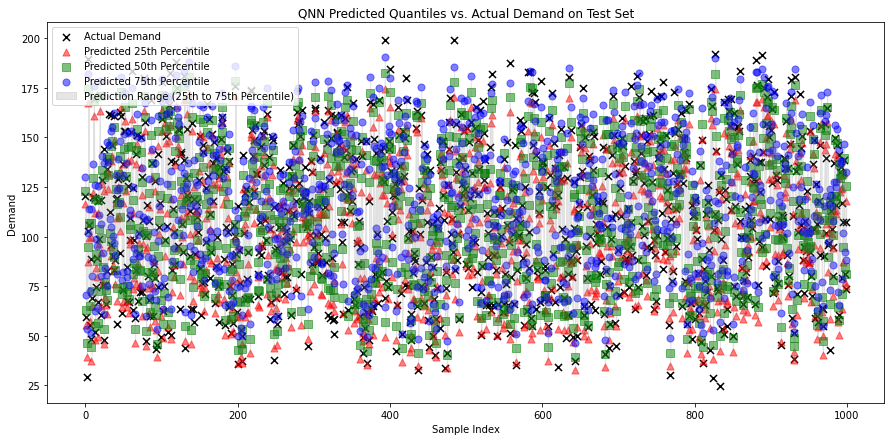

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure X_test_tensor is created from the test set
# Note: This should already be defined from when you performed the train-test split and evaluation.
# X_test_tensor = torch.tensor(X_test, dtype=torch.float32)  # This line is just a reminder.

# Assuming the model has been trained and is ready for evaluation
with torch.no_grad():
    model.eval()  # Ensure the model is in evaluation mode
    predictions_tensor = model(X_test_tensor)
    predictions = predictions_tensor.cpu().numpy()  # Convert to numpy for easier handling

# Select a product to visualize, for example, product 1
product_index = 0  # Change to 1 for product 2, if desired

# Extracting actual demands and predicted quantiles for the selected product from the test set
actual_demand = Y_test[:, product_index]  # Use Y_test for actual demands from the test set
pred_25th = predictions[:, product_index * 3]  # Adjust based on product index and output structure
pred_50th = predictions[:, product_index * 3 + 1]
pred_75th = predictions[:, product_index * 3 + 2]

# Indices for plotting
indices = np.arange(len(actual_demand))

plt.figure(figsize=(15, 7))

# Plot actual demands
plt.scatter(indices, actual_demand, color='black', label='Actual Demand', marker='x', s=50)

# Plot predicted quantiles
plt.scatter(indices, pred_25th, color='red', label='Predicted 25th Percentile', alpha=0.5, marker='^', s=50)
plt.scatter(indices, pred_50th, color='green', label='Predicted 50th Percentile', alpha=0.5, marker='s', s=50)
plt.scatter(indices, pred_75th, color='blue', label='Predicted 75th Percentile', alpha=0.5, marker='o', s=50)

# Optionally, add a fill between the 25th and 75th percentile predictions to highlight the prediction range
plt.fill_between(indices, pred_25th, pred_75th, color='gray', alpha=0.2, label='Prediction Range (25th to 75th Percentile)')

plt.title('QNN Predicted Quantiles vs. Actual Demand on Test Set')
plt.xlabel('Sample Index')
plt.ylabel('Demand')
plt.legend()
plt.show()



In [19]:
import numpy as np

# Ensure predictions are made on the test set and stored in `predictions`
# For this example, let's assume `predictions` were made using `X_test_tensor` as shown previously

# Extracting actual demands and predicted quantiles for the first product from the test set
actual_demand_product1 = Y_test[:, 0]  # Use Y_test for actual demands from the test set
pred_25th_percentile = predictions[:, 0]  # 25th percentile predictions for product 1
pred_75th_percentile = predictions[:, 2]  # 75th percentile predictions for product 1

# Counting the data points in the test set
total_points = len(actual_demand_product1)
above_75 = np.sum(actual_demand_product1 > pred_75th_percentile)
below_25 = np.sum(actual_demand_product1 < pred_25th_percentile)
between_25_75 = np.sum((actual_demand_product1 >= pred_25th_percentile) & (actual_demand_product1 <= pred_75th_percentile))

# Calculating percentages
percentage_above_75 = (above_75 / total_points) * 100
percentage_below_25 = (below_25 / total_points) * 100
percentage_between_25_75 = (between_25_75 / total_points) * 100

# Printing the results
print(f"Percentage of data points above the 75th percentile: {percentage_above_75:.2f}%")
print(f"Percentage of data points below the 25th percentile: {percentage_below_25:.2f}%")
print(f"Percentage of data points between the 25th and 75th percentiles: {percentage_between_25_75:.2f}%")



Percentage of data points above the 75th percentile: 23.80%
Percentage of data points below the 25th percentile: 24.30%
Percentage of data points between the 25th and 75th percentiles: 51.90%


In [77]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Generate synthetic data: features (day of the week) and targets (demand)
np.random.seed(0)
days = np.random.randint(1, 8, size=100)
demand = days * 10 + np.random.normal(0, 2, size=100)  # Simplified demand equation

# Convert to PyTorch tensors
X = torch.tensor(days, dtype=torch.float32).view(-1, 1)
Y = torch.tensor(demand, dtype=torch.float32).view(-1, 1)

# Define a simple NN model
class DemandPredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 10)
        self.fc2 = nn.Linear(10, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initial training
model = DemandPredictor()
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

# Train for a few epochs
for epoch in range(100):
    optimizer.zero_grad()
    predictions = model(X)
    loss = loss_fn(predictions, Y)
    loss.backward()
    optimizer.step()

# Simplified "MIP" optimization: decide production quantity to maximize profit
def simple_mip_solver(demand_prediction, production_cost=2, selling_price=5, capacity=120, surplus_cost=1):
    """
    A simplified MIP solver to decide the optimal production quantity.
    
    Parameters:
    - demand_prediction: The predicted demand for the product.
    - production_cost: Cost to produce one unit of the product.
    - selling_price: Selling price of one unit of the product.
    - capacity: Maximum production capacity.
    - surplus_cost: Cost incurred per unit of unsold product.
    
    Returns:
    - Optimal production quantity to maximize profit considering constraints.
    """
    # Define profit function based on production quantity
    def profit(production_quantity):
        sales_revenue = min(production_quantity, demand_prediction) * selling_price
        production_expense = production_quantity * production_cost
        surplus_expense = max(0, production_quantity - demand_prediction) * surplus_cost
        
        return sales_revenue - production_expense - surplus_expense
    
    # Check production from 0 to capacity to find max profit
    max_profit = -float('inf')
    optimal_production = 0
    for production_quantity in range(capacity + 1):
        current_profit = profit(production_quantity)
        if current_profit > max_profit:
            max_profit = current_profit
            optimal_production = production_quantity
    
    return optimal_production

# Assuming alpha represents the weight given to the new information (actual sales or decision outcome)
alpha = 0.7

# Iteration between optimization decision-making and NN retraining
for iteration in range(5):
    with torch.no_grad():
        # For a given feature input (e.g., day of the week = 5)
        demand_prediction = model(torch.tensor([[5]], dtype=torch.float32)).item()

    # Simplified "MIP" decision (could be more complex in practice)
    production_decision = simple_mip_solver(demand_prediction)

    # Simulate actual sales with added variability
    actual_sales = production_decision + np.random.normal(0, 1)

    # Generate new training data point (weighted average of prediction and actual outcome)
    new_x = torch.tensor([[5]], dtype=torch.float32)
    new_y = torch.tensor([[alpha * actual_sales + (1 - alpha) * demand_prediction]], dtype=torch.float32)

    # Append new data point to the training set (for simplicity, we're directly adding; in practice, manage dataset size and balance)
    X = torch.cat((X, new_x), 0)
    Y = torch.cat((Y, new_y), 0)

    # Retrain the model with the updated dataset
    for epoch in range(10):  # Short retraining phase
        optimizer.zero_grad()
        predictions = model(X)
        loss = loss_fn(predictions, Y)
        loss.backward()
        optimizer.step()
    
    print(f"Iteration {iteration+1}, Production Decision: {production_decision}, Actual Sales: {actual_sales:.2f}, New Training Point: {new_y.item():.2f}")


Iteration 1, Production Decision: 49, Actual Sales: 50.04, New Training Point: 49.88
Iteration 2, Production Decision: 51, Actual Sales: 50.97, New Training Point: 50.91
Iteration 3, Production Decision: 51, Actual Sales: 51.07, New Training Point: 50.90
Iteration 4, Production Decision: 50, Actual Sales: 50.27, New Training Point: 50.12
Iteration 5, Production Decision: 49, Actual Sales: 50.15, New Training Point: 49.89


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Generate synthetic demand data
np.random.seed(0)
demand_samples = np.random.normal(100, 20, size=500)  # Mean demand of 100 with a standard deviation of 20

# Simplified cost function for ordering and holding/shortage
def first_stage_cost(order_qty, demand, order_cost=10, holding_cost=2, shortage_cost=5):
    # Assume linear cost for ordering, holding, and shortage
    holding_or_shortage = np.maximum(0, order_qty - demand) * holding_cost - np.minimum(0, order_qty - demand) * shortage_cost
    return order_cost * order_qty + holding_or_shortage

# Neural Network for approximating second-stage cost
class SecondStageCostNN(nn.Module):
    def __init__(self):
        super(SecondStageCostNN, self).__init__()
        self.fc1 = nn.Linear(2, 10)  # Input layer: order_qty and demand
        self.fc2 = nn.Linear(10, 1)  # Output layer: approximated second-stage cost

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the neural network
model = SecondStageCostNN()
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# Simplified alternating optimization and NN training process
for iteration in range(10):  # Number of iterations for alternating process
    order_qty = 100  # Simplified first-stage decision (e.g., result from optimization)
    
    # Generate second-stage data points (order_qty, demand) and costs
    X_train = torch.tensor([(order_qty, d) for d in demand_samples], dtype=torch.float32)
    Y_train = torch.tensor([first_stage_cost(order_qty, d) for d in demand_samples], dtype=torch.float32).view(-1, 1)
    
    # Train the NN with current data
    model.train()
    for epoch in range(100):  # Number of epochs for training
        optimizer.zero_grad()
        predictions = model(X_train)
        loss = criterion(predictions, Y_train)
        loss.backward()
        optimizer.step()

    # Assume a step to update the first-stage decision based on NN insights (simplified)
    # In a real scenario, this would involve solving an optimization problem using the NN

print("Simplified alternating optimization and NN training completed.")



In the given simulation, we explored a two-stage stochastic optimization framework using a Quantile Neural Network (QNN) to inform first-stage investment decisions under uncertainty. This methodological approach integrates advanced neural network predictions with traditional optimization techniques to manage and navigate the complexities inherent in stochastic problems. Here's a breakdown of the methodology and its application in the simulation:

Step 1: Synthetic Data Generation
The first step involved generating synthetic data to simulate the uncertain future returns of different assets in a portfolio. This synthetic dataset serves as a proxy for the uncertain outcomes that investments might yield, reflecting the inherent variability and risk in financial markets.

Step 2: Quantile Neural Network (QNN) Definition
A QNN was defined to predict the distribution of returns (or costs) associated with different investment allocations. Unlike standard neural networks that predict a single expected value, QNNs are designed to estimate various quantiles of the outcome distribution, providing a more comprehensive view of the potential variability and risk.

Step 3: Sample Average Approximation (SAA) for Benchmarking
The Sample Average Approximation (SAA) method was employed as a traditional benchmark for comparison. SAA uses sample means of the outcomes to make decisions, focusing on average performance without explicitly modeling the distribution of outcomes. This step highlights a conventional approach in contrast to the more distribution-aware method introduced by the QNN.

Step 4: Training the QNN
The QNN was trained on the synthetic dataset to learn the relationship between investment allocations and their associated distribution of returns. Training a QNN involves optimizing it to minimize a loss function that accounts for the errors in quantile predictions, enabling the network to accurately estimate the desired quantiles of the outcome distribution.

Step 5: Evaluating Different Allocations with the QNN
The core of the methodology lies in using the trained QNN to evaluate various investment allocations. By inputting different allocation strategies into the QNN, we obtain predictions for the quantiles of returns, which inform us about the expected outcomes and associated risks (variability) of each allocation.

Step 6: Selection of Optimal Allocation
The final step involves selecting the optimal allocation based on the QNN's predictions. This decision-making process considers both the expected returns and the associated risks, aiming to find a balance that aligns with the investor's risk-return preferences. The selection criteria can be adjusted to prioritize either higher returns or lower risk, depending on the investment strategy.

Methodological Innovations
Risk-Aware Decision Making: By estimating the full distribution of outcomes, the QNN enables more nuanced and risk-aware investment decisions compared to methods that only consider average returns.
Efficient Handling of Uncertainty: The QNN framework provides an efficient way to model and navigate the uncertainty inherent in stochastic optimization problems, offering a significant advantage over traditional approaches that may require extensive sampling or scenario analysis.
Adaptability and Flexibility: The approach is highly adaptable, allowing for the incorporation of various risk metrics and decision criteria based on the quantile predictions. This flexibility makes it applicable across a wide range of stochastic optimization problems.
This simulation showcases how advanced machine learning techniques, specifically QNNs, can be integrated with traditional optimization methods to enhance decision-making under uncertainty. This methodological approach offers valuable insights and tools for addressing complex stochastic problems across various domains.



Step 1: Generate Synthetic Data for Asset Returns

In [99]:
def generate_returns_with_covariance(num_scenarios, num_assets, seed=43):
    np.random.seed(seed)

    # Simulate base returns with a simple trend and random shocks
    base_returns = np.random.normal(loc=0.1, scale=0.02, size=(num_scenarios, num_assets))
    
    # Add a linear trend to reflect gradual improvement or deterioration
    trends = np.linspace(0, 0.02, num_scenarios).reshape(-1, 1)
    
    # Introduce random shocks with higher magnitude events sporadically
    shocks = np.random.normal(0, 0.05, (num_scenarios, num_assets))
    major_shock_indices = np.random.randint(0, num_scenarios, size=20)
    shocks[major_shock_indices, np.random.choice(num_assets, size=20)] = np.random.normal(0.1, 0.05, 20)
    
    # Combine base returns, trends, and shocks
    returns = base_returns + trends + shocks

    # Introduce covariance between assets
    # Simulate a covariance matrix (simplified and positive definite)
    cov_matrix = np.array([[0.04, 0.01, 0.02], 
                           [0.01, 0.05, 0.01], 
                           [0.02, 0.01, 0.03]])
    cholesky_decomp = np.linalg.cholesky(cov_matrix)
    
    correlated_returns = returns.dot(cholesky_decomp.T)

    return correlated_returns

num_scenarios = 100
num_assets = 3
returns = generate_returns_with_covariance(num_scenarios, num_assets)


Step 2: Prepare the Data for Neural Network Training
Given the returns with covariance, we need to format the data properly for the neural network. This includes splitting the data into features (X) and targets (Y), normalizing the data, and creating training and testing datasets.

In [100]:
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Normalize the data
scaler = StandardScaler()
returns_normalized = scaler.fit_transform(returns)

# Splitting into features and targets
# Assuming the task is to use past return as feature to predict future return
X = returns_normalized[:-1]  # All but last to use as features
Y = returns_normalized[1:]  # All but first as target returns

# Split data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)


Step 3: Define and Train the Quantile Neural Network (QNN)
Let's define a QNN suitable for predicting the future returns' quantiles:

In [101]:
class QNN(nn.Module):
    def __init__(self):
        super(QNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(num_assets, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, num_assets * 3)  # Predict 3 quantiles per asset
        )
    
    def forward(self, x):
        return self.network(x)

# Initialize the QNN
qnn = QNN()
optimizer = torch.optim.Adam(qnn.parameters(), lr=0.001)

# Assuming a custom loss function for quantile regression (e.g., pinball loss)
def quantile_loss(preds, target, quantiles=[0.25, 0.5, 0.75]):
    assert preds.shape[1] == len(quantiles) * num_assets  # 3 quantiles for each asset
    losses = []
    for i, q in enumerate(quantiles):
        errors = target - preds[:, i::len(quantiles)]
        losses.append(torch.max((q-1) * errors, q * errors).unsqueeze(1))
    loss = torch.mean(torch.sum(torch.cat(losses, dim=1), dim=1))
    return loss

# Train the QNN
for epoch in range(200):
    qnn.train()
    optimizer.zero_grad()
    predictions = qnn(X_train_tensor)
    loss = quantile_loss(predictions, Y_train_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print(f'Epoch {epoch}: Loss = {loss.item()}')


Epoch 0: Loss = 1.2256642580032349
Epoch 50: Loss = 0.9825118184089661
Epoch 100: Loss = 0.9181954860687256
Epoch 150: Loss = 0.8637505769729614


In [103]:
def optimize_portfolio(predictions, quantiles=[0.25, 0.5, 0.75], num_assets=3):
    # Extracting predicted quantiles for each asset
    lower_quantile_returns = predictions[:, :num_assets]  # 25th percentile
    median_quantile_returns = predictions[:, num_assets:2*num_assets]  # 50th percentile
    upper_quantile_returns = predictions[:, 2*num_assets:]  # 75th percentile
    
    # Calculating mean predicted returns and risk for each asset
    mean_returns = median_quantile_returns.mean(0)
    risk = upper_quantile_returns.mean(0) - lower_quantile_returns.mean(0)  # Risk as the spread between 75th and 25th quantiles
    
    # Calculating a simple return-to-risk ratio for each asset
    return_to_risk_ratio = mean_returns / risk
    
    # Optimal asset allocation aims to maximize this ratio
    optimal_asset_index = torch.argmax(return_to_risk_ratio)
    optimal_weights = torch.zeros(num_assets)
    optimal_weights[optimal_asset_index] = 1  # Simplified allocation to the asset with the best return-to-risk ratio
    
    return optimal_weights.numpy()

# Assuming qnn is already trained and we have the latest X_test_tensor
qnn.eval()
with torch.no_grad():
    predictions = qnn(X_test_tensor)
    optimal_weights = optimize_portfolio(predictions)

print(f'Optimal Portfolio Weights (Balancing Return and Risk): {optimal_weights}')


Optimal Portfolio Weights (Balancing Return and Risk): [1. 0. 0.]


Step 4: Portfolio Optimization Using QNN Predictions
After training the QNN, you can use its predictions to inform portfolio allocation decisions. The optimization process might consider not only the median predicted returns but also the associated risk (as indicated by the spread between the quantiles).

The following code provides a conceptual approach to using QNN predictions for optimization:

In [102]:
qnn.eval()
with torch.no_grad():
    # Get predictions for test data
    predictions = qnn(X_test_tensor)
    
    # Example: Select the asset with the highest median predicted return for simplicity
    median_returns = predictions[:, num_assets:2*num_assets]  # Extract median returns
    optimal_asset_index = torch.argmax(median_returns.mean(0))
    optimal_weights = torch.zeros(num_assets)
    optimal_weights[optimal_asset_index] = 1  # Allocate fully to the asset with highest median return

print(f'Optimal Portfolio Weights based on QNN: {optimal_weights.numpy()}')


Optimal Portfolio Weights based on QNN: [0. 0. 1.]


In [90]:
from scipy.optimize import minimize

def portfolio_return(weights, returns):
    """Calculate expected portfolio return as a scalar."""
    # Ensure scalar by summing up the product of weights and mean returns
    return np.sum(weights * returns.mean(axis=0))

def portfolio_volatility(weights, returns):
    """Calculate portfolio volatility as a scalar."""
    # Portfolio volatility is the square root of the portfolio variance
    # Portfolio variance is a weighted covariance matrix product
    portfolio_var = np.dot(weights.T, np.dot(np.cov(returns.T, bias=True), weights))
    return np.sqrt(portfolio_var)

# Redefine the objective function to maximize return (or minimize negative return)
def objective(weights):
    """Objective function to be minimized."""
    # Minimize the negative return to maximize return
    return -portfolio_return(weights, returns)

# Constraints: Ensure weights sum to 1
constraints = [{'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}]

# Bounds: Each weight can range from 0 to 1
bounds = [(0, 1) for _ in range(num_assets)]

# Initial guess: Equal allocation
initial_guess = np.array([1./num_assets] * num_assets)

# Perform the optimization
opt_result = minimize(objective, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)

print("Optimal Weights (Traditional):", opt_result.x)


Optimal Weights (Traditional): [0.         0.50600568 0.49399432]


Step 2: Define the QNN for Approximating the Second Stage

In [96]:
import torch
import torch.nn as nn
import torch.optim as optim

class EnhancedQuantileNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(EnhancedQuantileNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_size)  # Output size for quantiles per asset
        )
    
    def forward(self, x):
        return self.network(x)



Step 3: Sample Average Approximation (SAA) for First Stage
For simplicity, let's solve a deterministic version of the optimization problem using SAA, focusing on the average returns. In practice, this step might involve more complex optimization techniques and solvers.

In [94]:
# For the SAA, we use average returns to make allocation decisions
average_returns = np.mean(returns, axis=0)
allocation = average_returns / np.sum(average_returns)  # Simplistic allocation based on average returns

print(f"Allocation based on SAA: {allocation}")


Allocation based on SAA: [0.28077887 0.36054866 0.35867247]


Step 4: Train the QNN on the Second Stage Using Synthetic Data
This step involves defining a loss function suitable for quantile regression, such as the pinball loss, and training the QNN to predict risk measures (e.g., CVaR) based on different allocations.

In [98]:
# Assuming returns are numpy array from generate_returns_with_covariance function
# Normalize data (this step is crucial for training neural networks effectively)
returns_normalized = (returns - returns.mean(axis=0)) / returns.std(axis=0)

# Convert to PyTorch tensors for training
X_train = torch.tensor(returns_normalized[:-10], dtype=torch.float32)  # Use most data for training
Y_train = torch.tensor(returns_normalized[1:], dtype=torch.float32)    # Predict next time step
# Placeholder adjustment - In practice, you'd have specific quantile targets
Y_train_expanded = torch.cat([Y_train for _ in range(3)], axis=1)  # Duplicate Y_train to match the model's output shape

# Verify shapes align now
print("Predictions shape:", model(X_train).shape)
print("Expanded Y_train shape:", Y_train_expanded.shape)
input_size = num_assets  # Number of assets
output_size = num_assets * 3  # Predicting 3 quantiles per asset
model = EnhancedQuantileNN(input_size=input_size, output_size=output_size)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Placeholder training loop - replace MSE with a proper quantile loss for actual use
for epoch in range(200):
    optimizer.zero_grad()
    predictions = model(X_train)
    loss = torch.mean((predictions - Y_train_expanded) ** 2)  # Updated to use the expanded Y_train
    loss.backward()
    optimizer.step()
    
    if epoch % 50 == 0:
        print(f'Epoch {epoch}: Loss = {loss.item()}')

    loss.backward()
    optimizer.step()
    
    if epoch % 50 == 0:
        print(f'Epoch {epoch}: Loss = {loss.item()}')



Predictions shape: torch.Size([90, 9])
Expanded Y_train shape: torch.Size([99, 9])


RuntimeError: The size of tensor a (90) must match the size of tensor b (99) at non-singleton dimension 0

In [84]:
def evaluate_allocations(qnn, allocations):
    with torch.no_grad():
        risks = []
        expected_returns = []
        for allocation in allocations:
            simulated_returns = torch.tensor(allocation * returns, dtype=torch.float32)
            quantile_predictions = qnn(simulated_returns)
            expected_return = quantile_predictions[:, 1]
            risk = quantile_predictions[:, 2] - quantile_predictions[:, 0]
            risks.append(risk.mean().item())
            expected_returns.append(expected_return.mean().item())
        
        risks = np.array(risks)
        expected_returns = np.array(expected_returns)
        min_expected_return = 0.05

        valid_indices = np.where(expected_returns >= min_expected_return)[0]

        if valid_indices.size > 0:
            best_allocation_index = valid_indices[np.argmin(risks[valid_indices])]
        else:
            # Fallback: Choose the allocation with the highest return
            print("No allocation met the return threshold. Choosing highest return instead.")
            best_allocation_index = np.argmax(expected_returns)
            
        return allocations[best_allocation_index], expected_returns[best_allocation_index], risks[best_allocation_index]
    
# Simplified function to select optimal portfolio based on QNN predictions
def select_optimal_portfolio(model, X_latest):
    with torch.no_grad():
        quantile_predictions = model(X_latest).numpy()
    median_returns = quantile_predictions[:, 1::3]  # Assuming order [25th, 50th, 75th] quantiles

    # Portfolio optimization logic could be complex, here we use a simplistic approach:
    # Choose the asset with the highest median predicted return
    optimal_asset_index = np.argmax(np.mean(median_returns, axis=0))
    optimal_weights = np.zeros(num_assets)
    optimal_weights[optimal_asset_index] = 1  # Invest fully in the chosen asset
    
    return optimal_weights

# Use the latest available returns for making the decision
X_latest = torch.tensor(returns_normalized[-10:], dtype=torch.float32)
optimal_weights = select_optimal_portfolio(model, X_latest)

print(f'Optimal Portfolio Weights based on QNN: {optimal_weights}')




In [85]:
# Generate a range of allocations for asset 1, keeping others constant
num_allocations = 10
allocations = np.linspace(0.1, 1.0, num_allocations)
simulated_allocations = np.array([np.array([alloc, 1-alloc, 0]) for alloc in allocations])

# Evaluate the allocations to find the best one
best_allocation, best_return, best_risk = evaluate_allocations(qnn, simulated_allocations)
print(f"Best Allocation: {best_allocation}, Expected Return: {best_return}, Risk (IQR): {best_risk}")


No allocation met the return threshold. Choosing highest return instead.
Best Allocation: [1. 0. 0.], Expected Return: -0.0204243715852499, Risk (IQR): 0.08836796134710312
